## Notebook set up

Submit your notebook to the class leaderboard on HuggingFace at [huggingface.co/spaces/gperdrizet/leaderboard](https://huggingface.co/spaces/gperdrizet/leaderboard)

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

Don't change any of the code in the Model evaluation section of the notebook, especially the output saving. Otherwise the leaderboard scoring may not work!

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [60]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder
)

# Put this at the top of your notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set a large number
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [61]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

In [62]:

print('housing_df Description:')
print(housing_df.describe().T)
print()
print(f'housing_df Shape:{housing_df.shape}')
print()
print('housing_df Info:')
print(housing_df.info())

print('Do we have any missing values:')
print(housing_df.isnull().sum()[housing_df.isnull().sum() > 0])
print()

print('Feature Columns with that have missing values:')
print(housing_df.isnull().sum()[housing_df.isnull().sum() > 0])
print()

print(housing_df.head(20))


housing_df Description:
               count         mean          std         min         25%          50%          75%           max
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400     3.534800     4.743250     15.000100
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000    29.000000    37.000000     52.000000
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716     5.229129     6.052381    141.909091
AveBedrms    20640.0     1.096675     0.473911    0.333333    1.006079     1.048780     1.099526     34.066667
Population   20640.0  1425.476744  1132.462122    3.000000  787.000000  1166.000000  1725.000000  35682.000000
AveOccup     20640.0     3.070655    10.386050    0.692308    2.429741     2.818116     3.282261   1243.333333
Latitude     20640.0    35.631861     2.135952   32.540000   33.930000    34.260000    37.710000     41.950000
Longitude    20640.0  -119.569704     2.003532 -124.350000 -121.800000  -118.490000  -11

#### Feature Distributions -- Histograms ####

Feature Columns to plot
Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'], dtype='object')
Number of Columns: 9


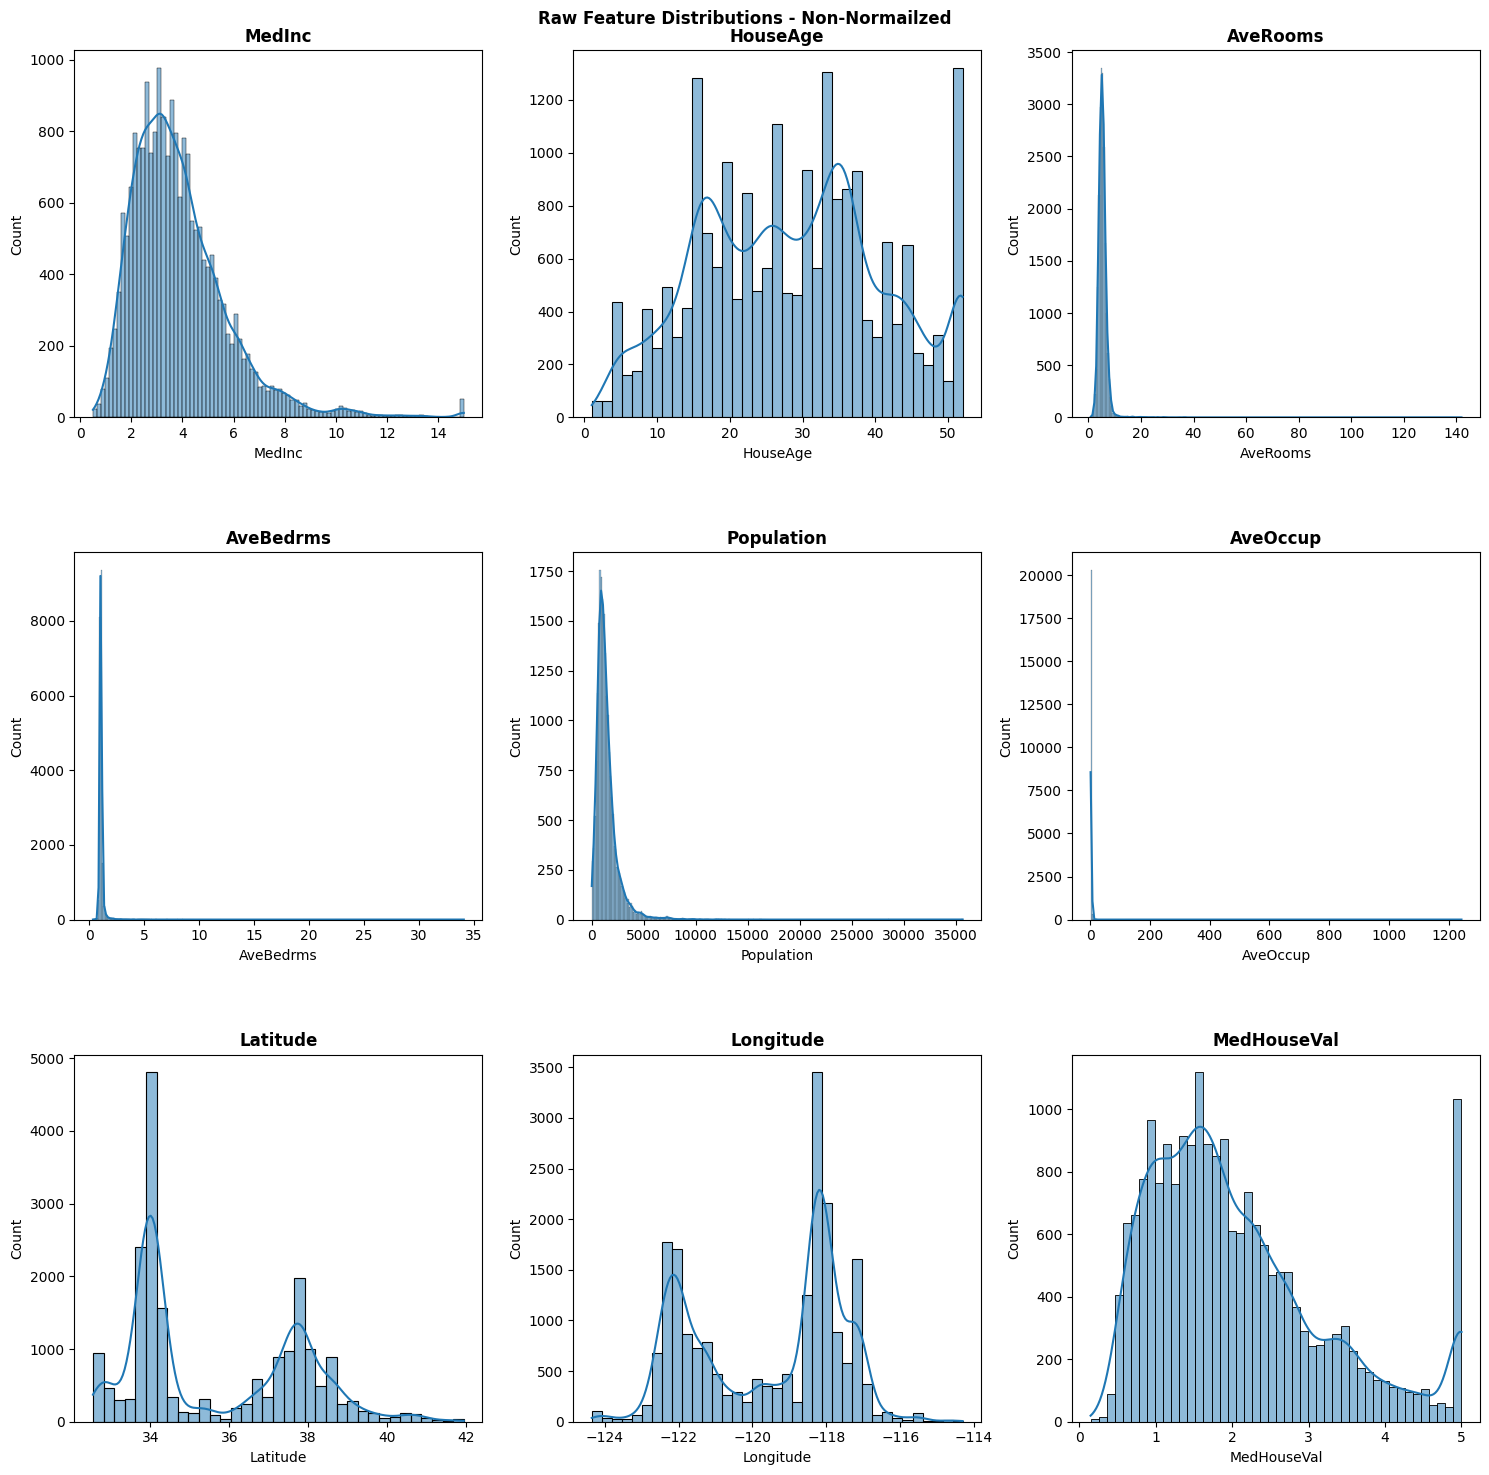

In [63]:
# The columns we want to plot:
print('Feature Columns to plot')
print(housing_df.columns)
columns_to_plot = housing_df.columns.tolist()

n_cols = len(columns_to_plot)
print(f'Number of Columns: {n_cols}')

# I need a 3X3 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Raw Feature Distributions - Non-Normailzed', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):
    sns.histplot(data=housing_df, x=col, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()   

#### Feature Distributions -- Box Plots ####

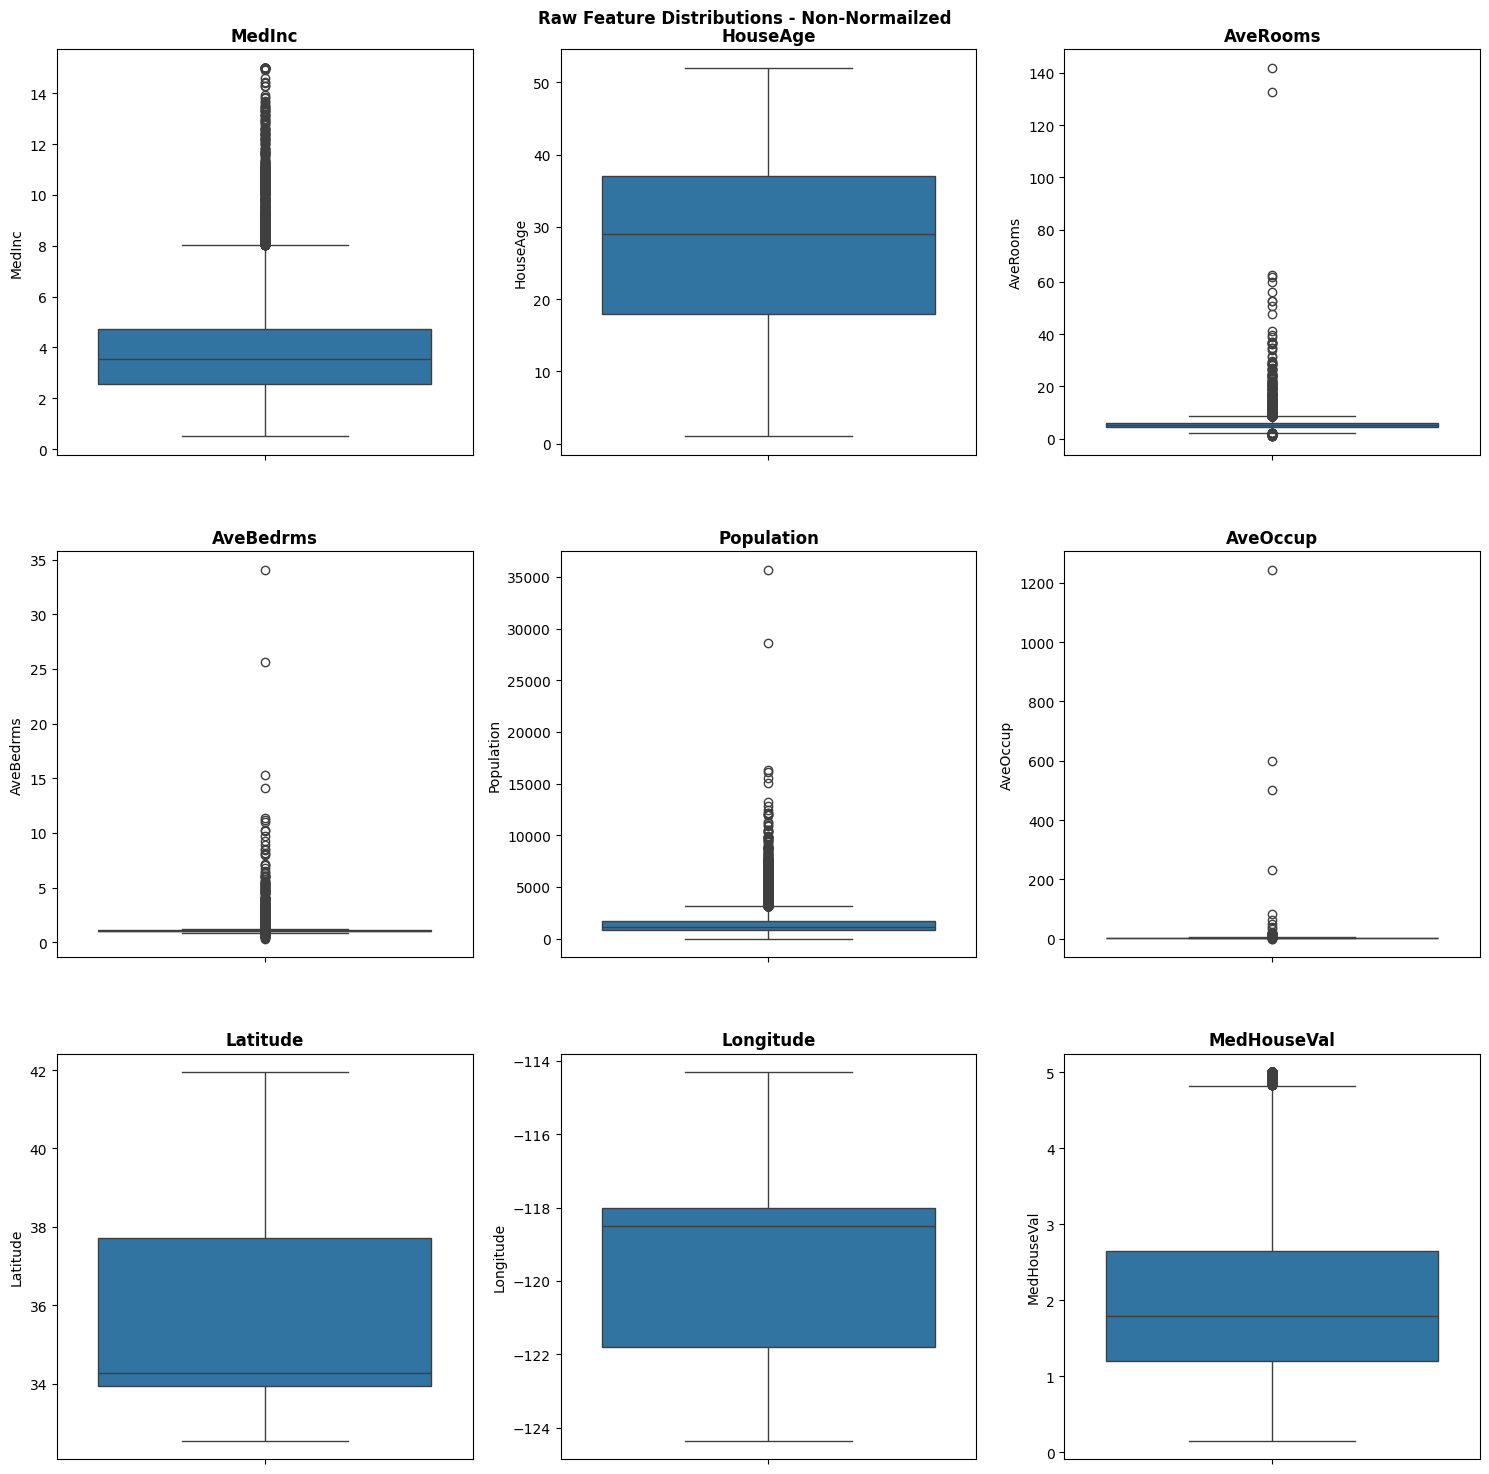

In [64]:
# I need a 3X3 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Raw Feature Distributions - Non-Normailzed', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=housing_df, y=col, ax=axes[i])    
    axes[i].set_title(col, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()   

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

#### Log Transformation ####

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


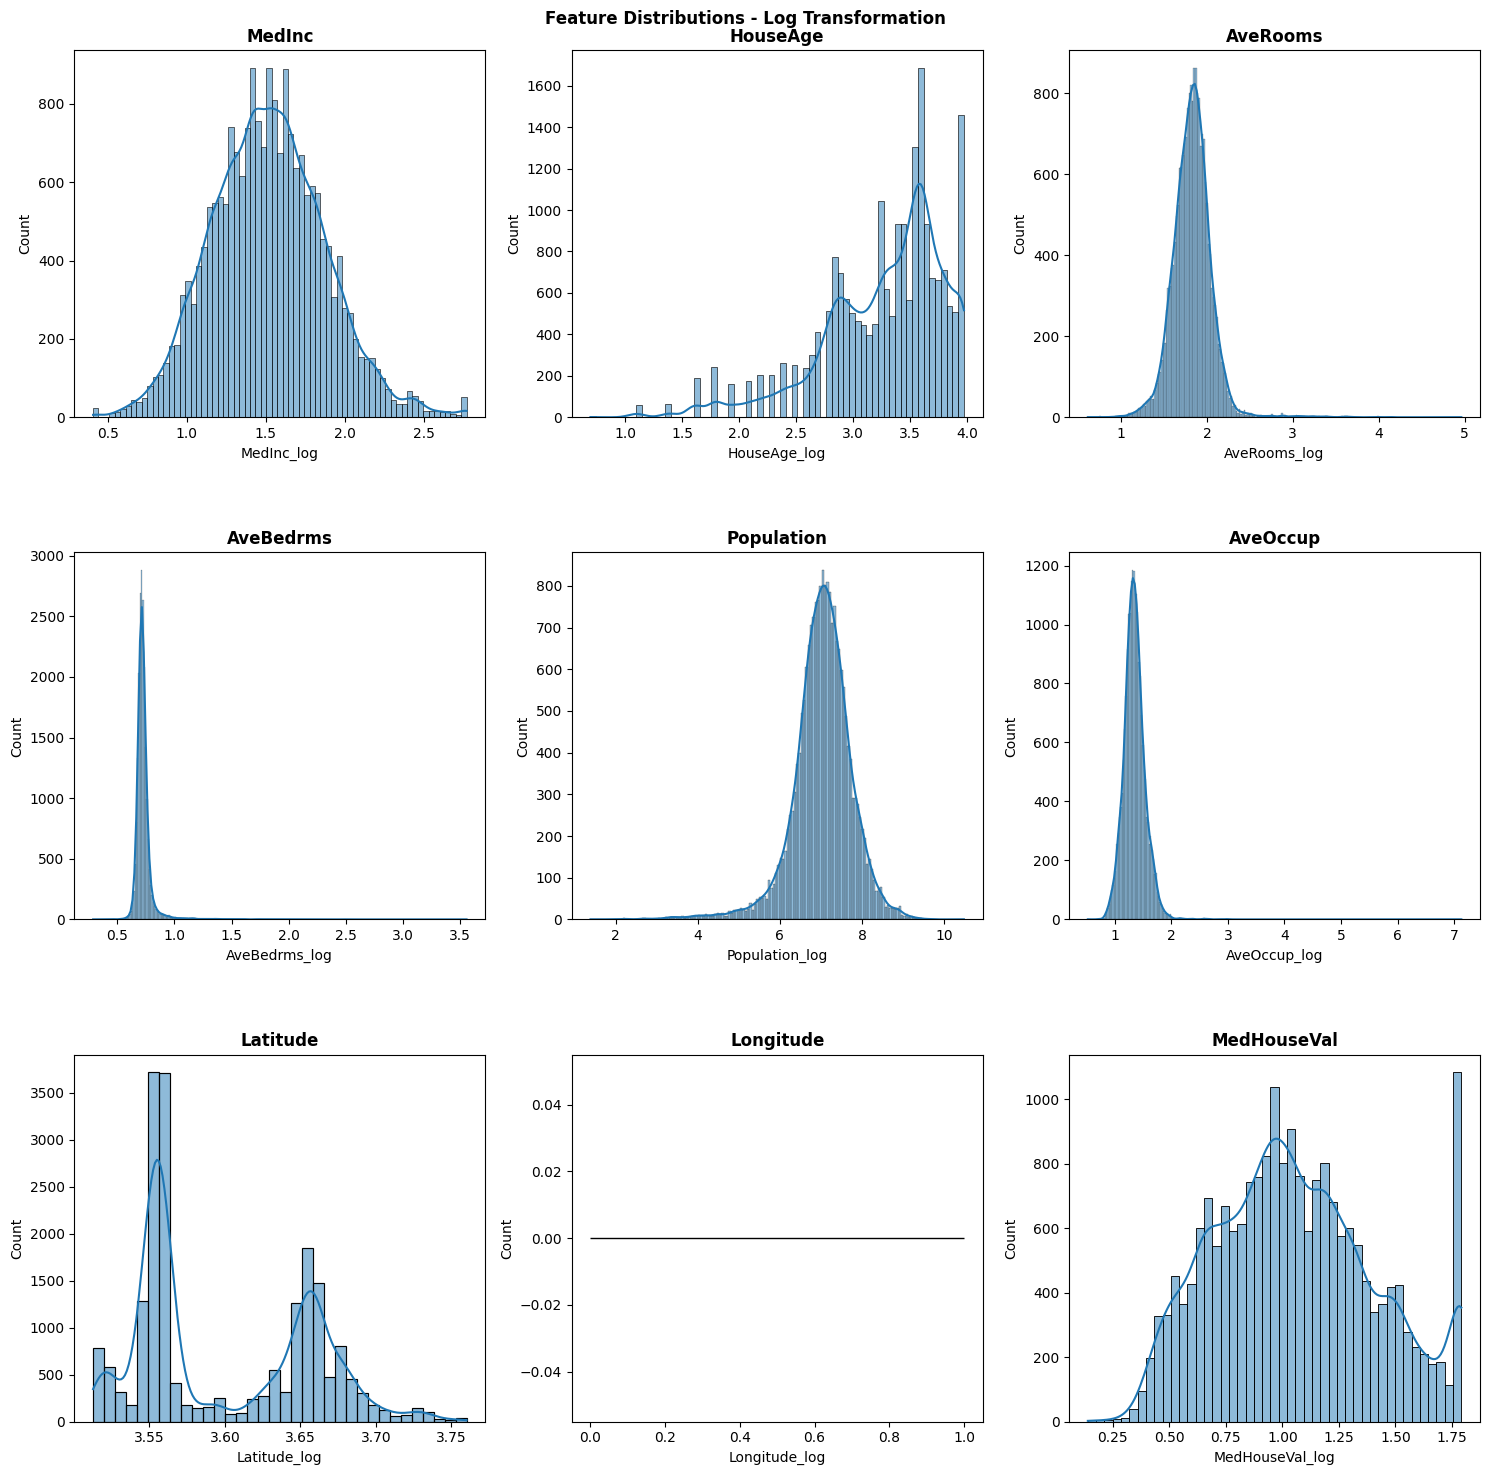

<Figure size 640x480 with 0 Axes>

In [65]:
#
# Try Log Transformations to normalize distributions
#
# I need a 3X3 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Feature Distributions - Log Transformation', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):

    # Apply log transformation (using log1p to handle zeros)
    feature_log = f'{col}_log'
    housing_df[f'{feature_log}'] = np.log1p(housing_df[col])

    sns.histplot(data=housing_df, x=feature_log, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()       

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show() 

#### Sqrt Transformation ####

c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


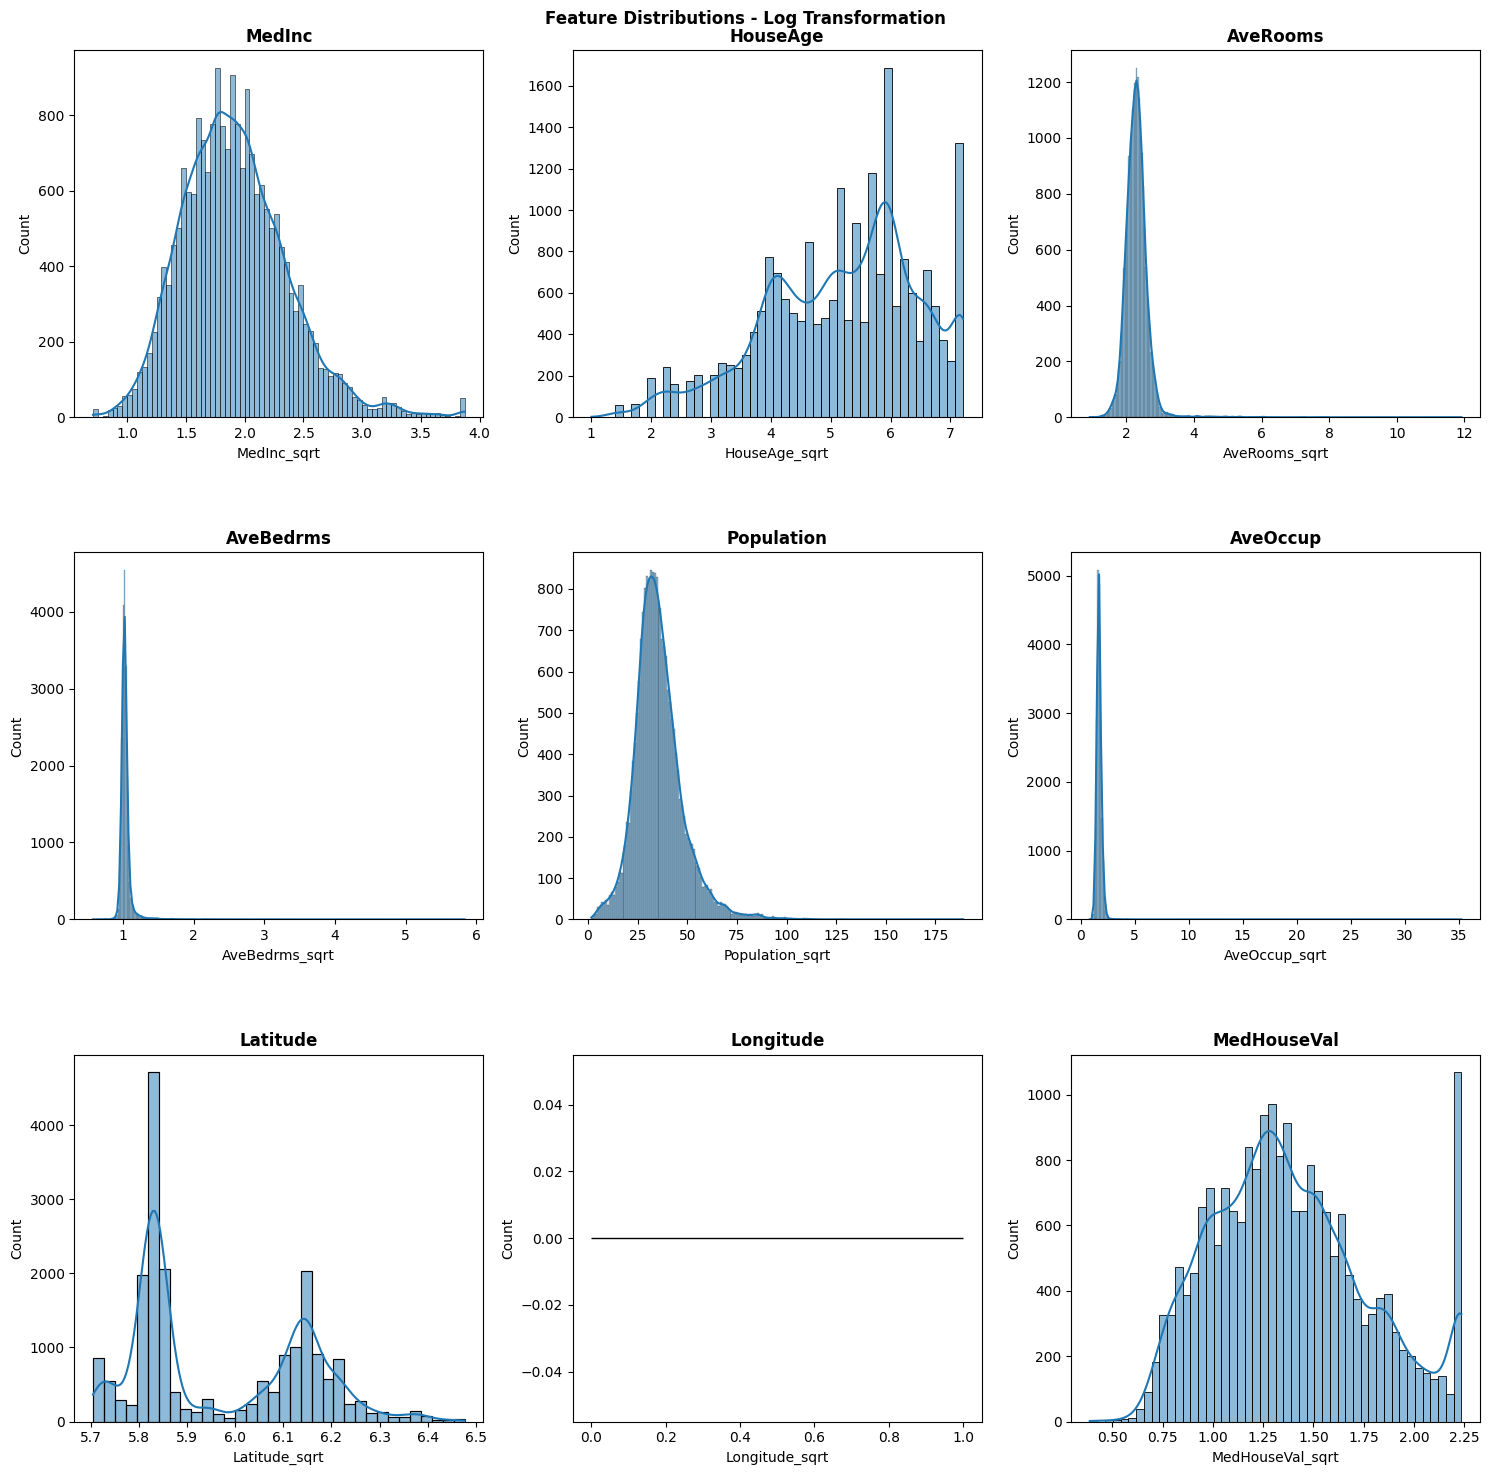

<Figure size 640x480 with 0 Axes>

In [66]:
#
# Try Sqrt Transformations to normalize distributions
#
# I need a 3X3 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

plt.suptitle('Feature Distributions - Log Transformation', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):

    # Apply log transformation (using log1p to handle zeros)
    feature_sqrt = f'{col}_sqrt'
    housing_df[f'{feature_sqrt}'] = np.sqrt(housing_df[col])

    sns.histplot(data=housing_df, x=feature_sqrt, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()       

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show() 


#### Power Transformation ####

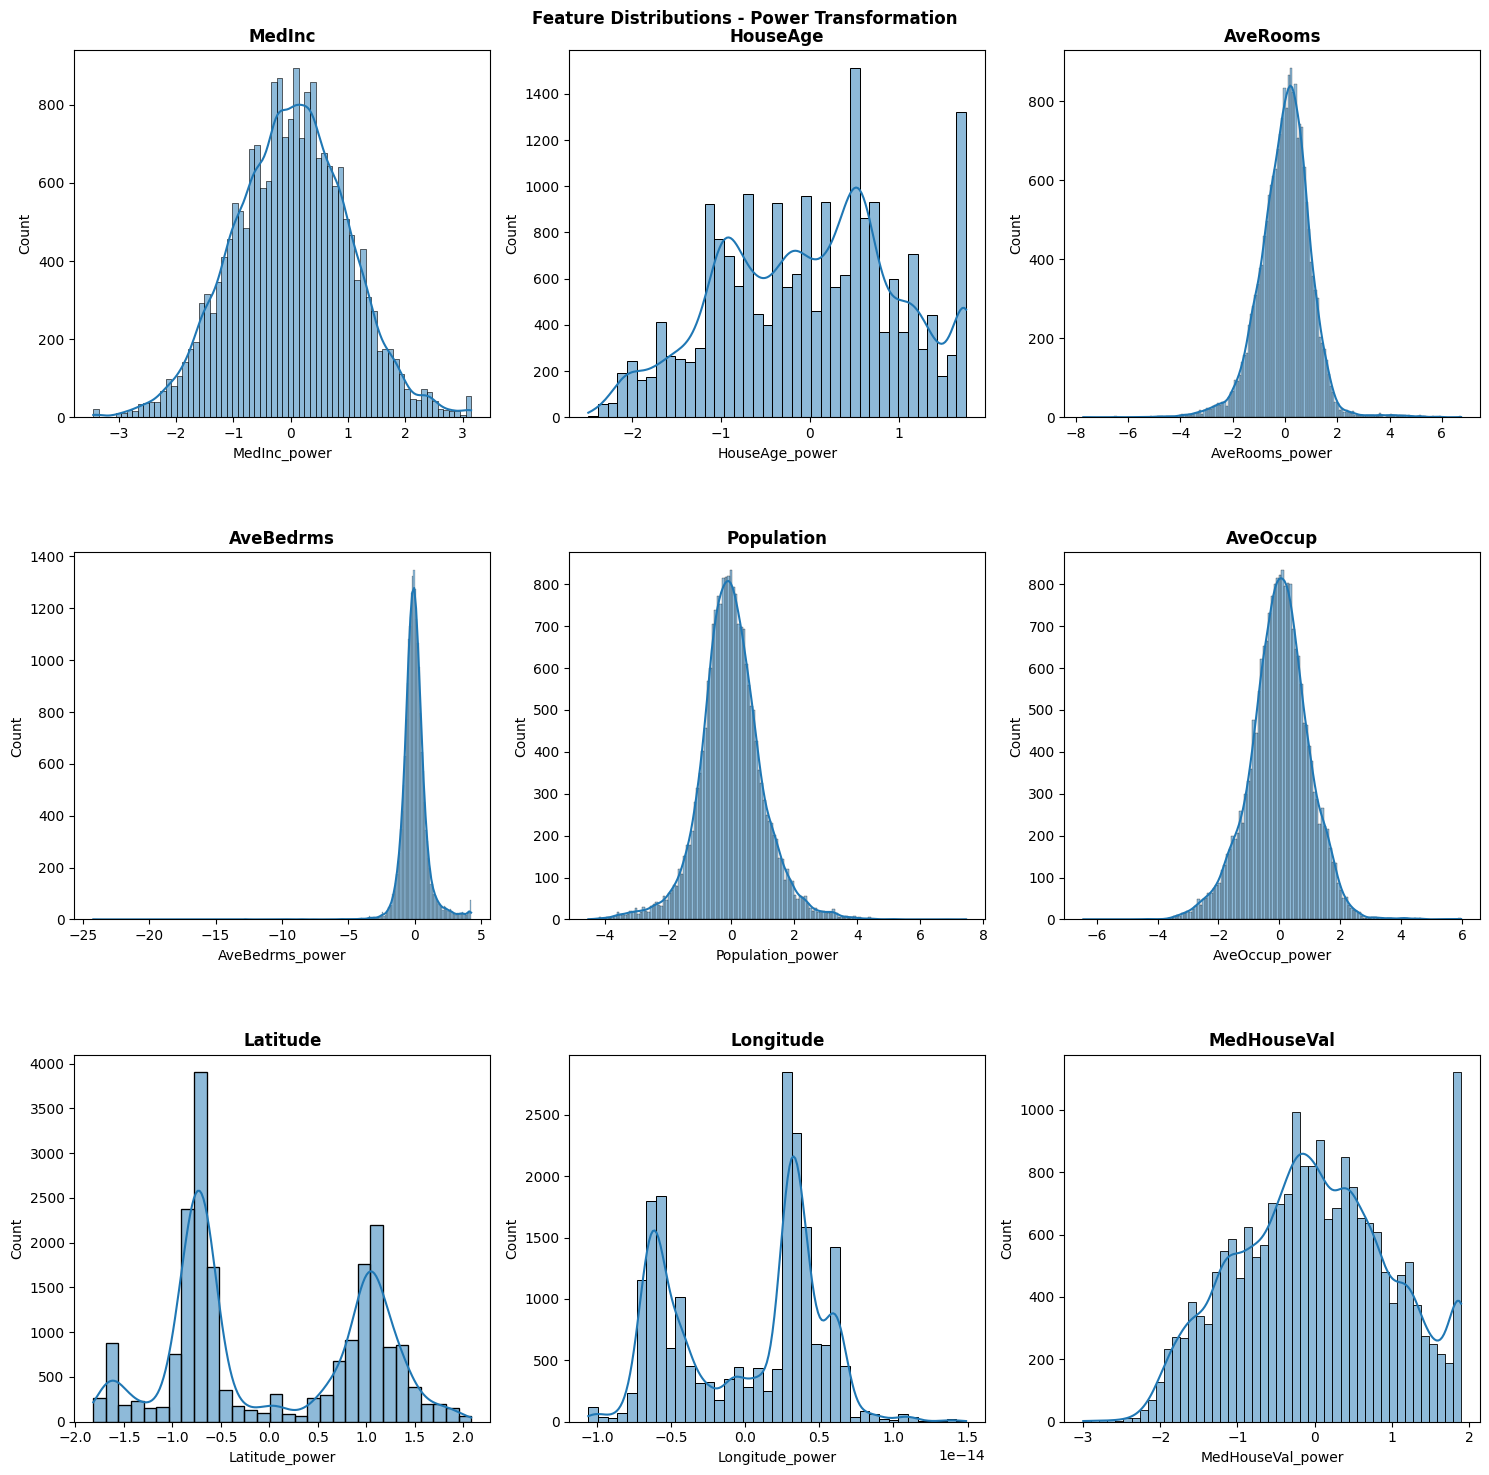

<Figure size 640x480 with 0 Axes>

In [67]:
#
# Try Power Transformations to normalize distributions
#
# I need a 3X3 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

# Apply power transformation using Yeo-Johnson (handles positive and negative values)
transformer = PowerTransformer(method='yeo-johnson')

plt.suptitle('Feature Distributions - Power Transformation', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):

    # Apply log transformation (using log1p to handle zeros)
    feature_power = f'{col}_power'

    # Fit and transform
    housing_df[f'{feature_power}'] = transformer.fit_transform(housing_df[[col]])
    sns.histplot(data=housing_df, x=feature_power, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()       

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show() 


#### Quantile Transformation ####

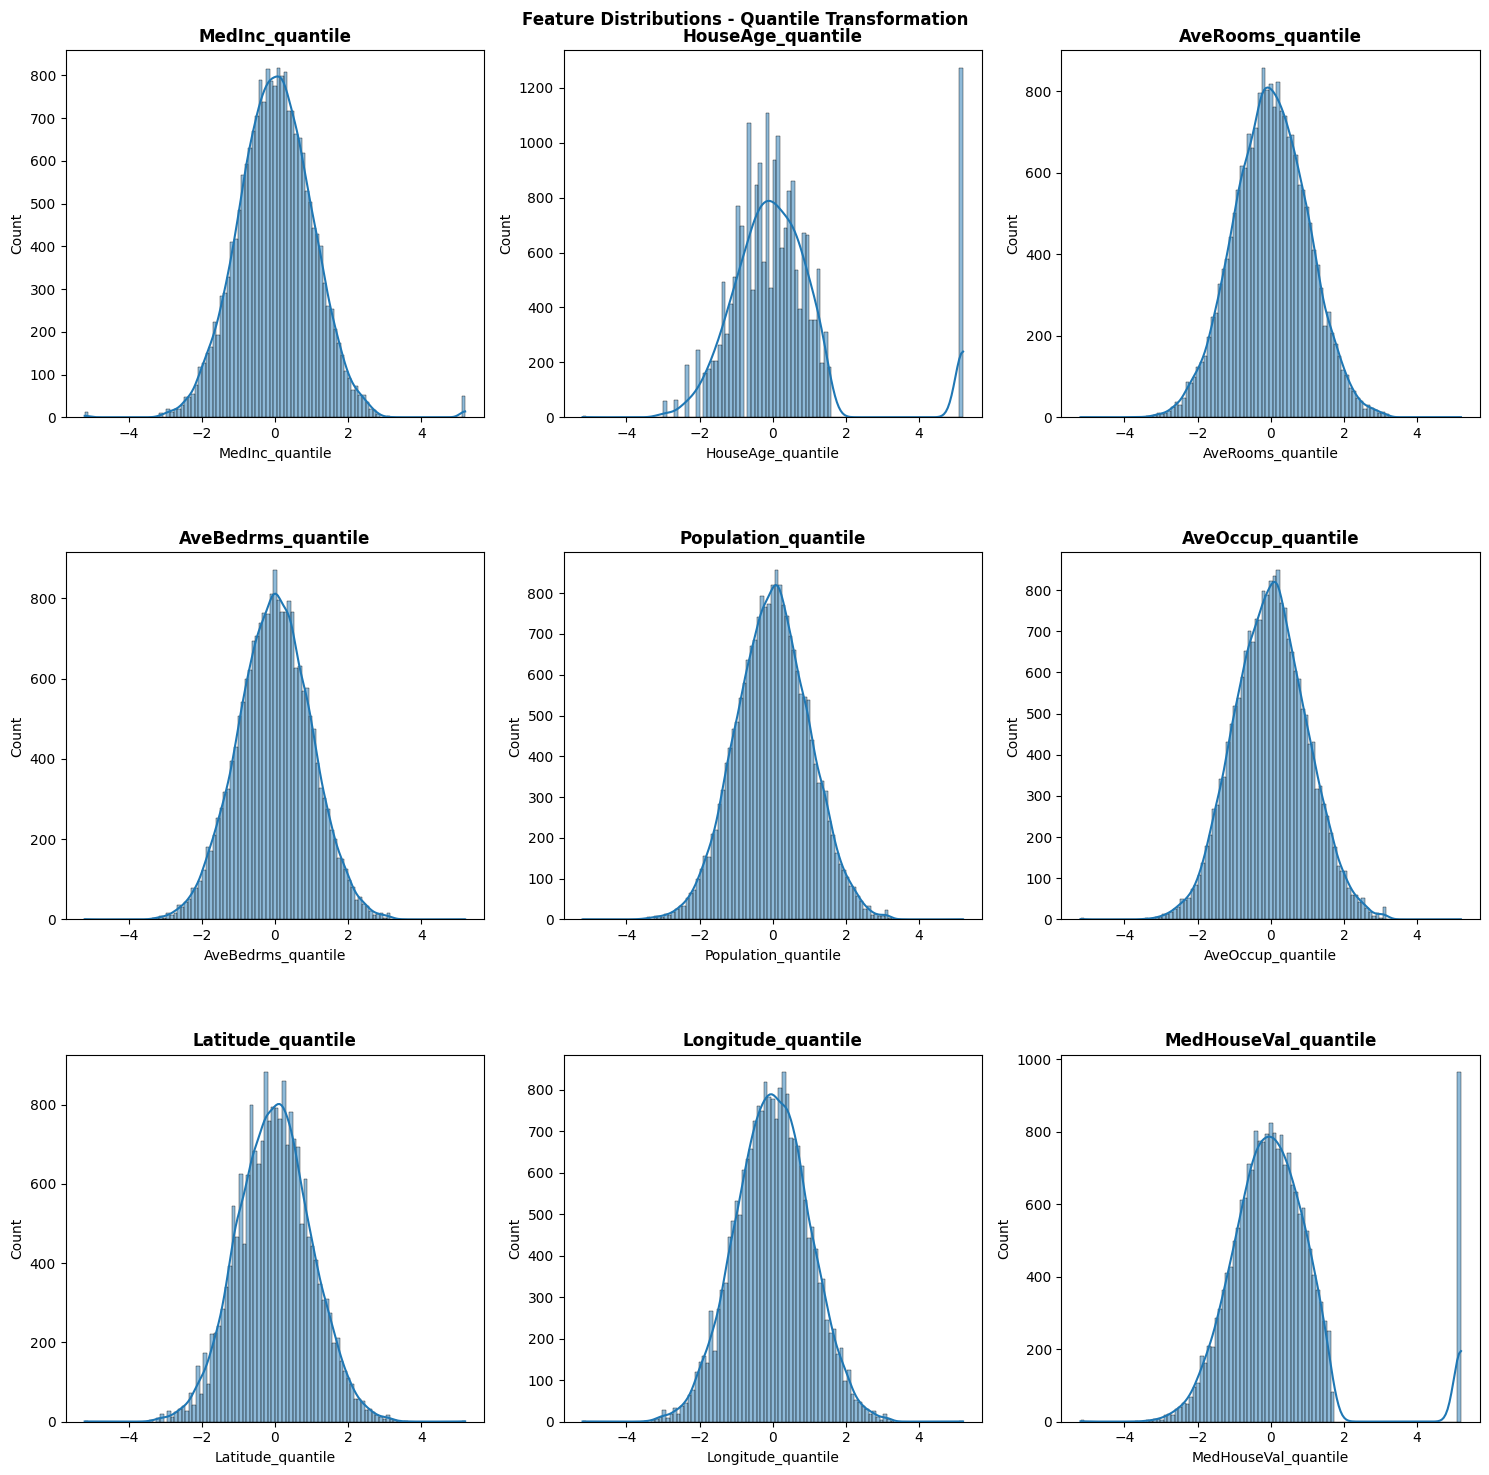

In [68]:
#
# Try Quantile Transformations to normalize distributions
#
# I need a 3X3 plot to display 10 histograms
fig, axes = plt.subplots(nrows=(n_cols + 2) // 3, ncols=3, figsize=(15, 5 * ((n_cols + 2) // 3)))
axes = axes.flatten()

# Apply quantile transformation to uniform distribution
transformer = QuantileTransformer(output_distribution='normal')

plt.suptitle('Feature Distributions - Quantile Transformation', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(columns_to_plot):

    # Apply log transformation (using log1p to handle zeros)
    feature_quantile = f'{col}_quantile'

    # Fit and transform
    housing_df[f'{feature_quantile}'] = transformer.fit_transform(housing_df[[col]])
    sns.histplot(data=housing_df, x=feature_quantile, ax=axes[i], kde=True)    
    axes[i].set_title(feature_quantile, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()       


#### Create Categories (bins) from Continous Data

##### HouseAge #####
    New (0-10 years), 
    Modern (11-25), 
    Older (26-40), 
    Historic (41+)

##### MedInc (Median Income) #####
    Low (0-3), 
    Lower-Middle (3-5), 
    Middle (5-7), 
    Upper-Middle (7-10), 
    Upper (10+)

##### Population - Density categories ######
    Small (<500), 
    Medium (500-1500), 
    Large (1500-3000), 
    Jumbo (3000+)

##### AveOccup (Average Occupancy) #####
    Low (<2), 
    Normal (2-3), 
    High (3-4), 
    Very High (4+)

Binning
Number of Columns: 9


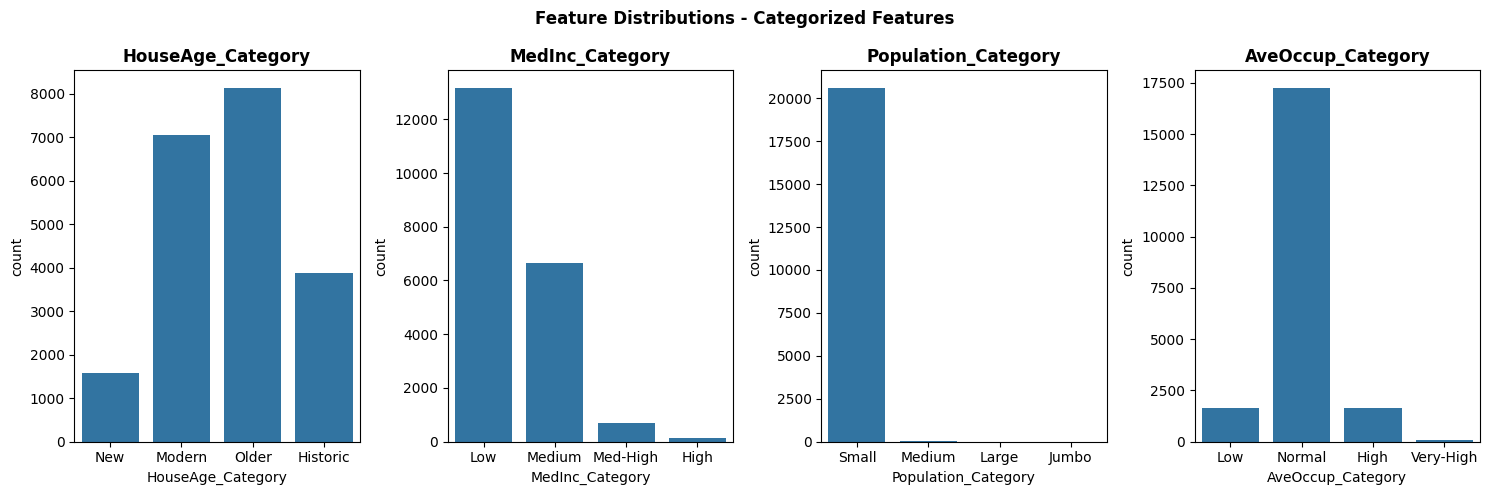

In [69]:
#
# Create Binned (Categoried) data
#

print('Binning')
# Create bins with specific edges
housing_df['HouseAge_Category'] = pd.cut(housing_df['HouseAge'], 
                                        bins=[0, 10, 25, 40, 100],
                                        labels=['New', 'Modern', 'Older', 'Historic'])

housing_df['MedInc_Category'] = pd.cut(housing_df['MedInc'], 
                                        bins=4,
                                        labels=['Low', 'Medium', 'Med-High', 'High'])

housing_df['Population_Category'] = pd.cut(housing_df['Population'], 
                                        bins=4,
                                        labels=['Small', 'Medium', 'Large', 'Jumbo'])                                        

housing_df['AveOccup_Category'] = pd.cut(housing_df['AveOccup'], 
                                       bins=[0,2,4,6,8],
                                       labels=['Low', 'Normal', 'High', 'Very-High'])

categories_to_plot = ['HouseAge_Category', 'MedInc_Category', 'Population_Category', 'AveOccup_Category']

n_cols = len(columns_to_plot)
print(f'Number of Columns: {n_cols}')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
axes = axes.flatten()

plt.suptitle('Feature Distributions - Categorized Features', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(categories_to_plot):

    sns.countplot(data=housing_df, x=col, ax=axes[i])
    axes[i].set_title(col, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()       

##### Creating Combined Features #####

Number of Columns: 4


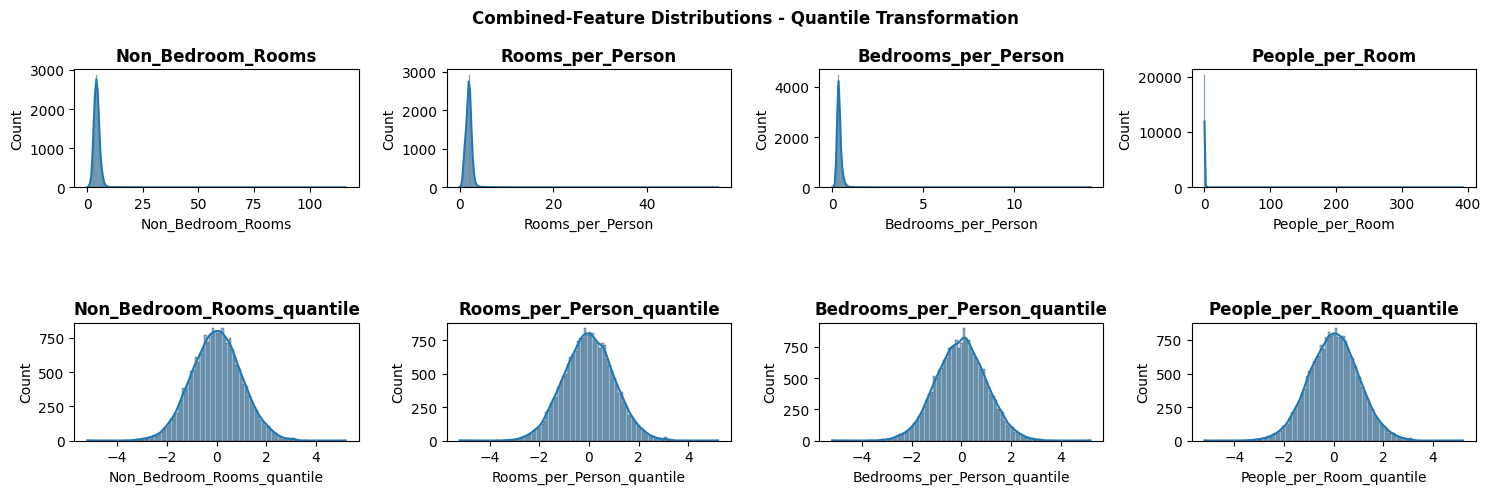

In [70]:
# Apply quantile transformation to uniform distribution
transformer = QuantileTransformer(output_distribution='normal')

# Non-bedroom rooms per household (living space)
housing_df['Non_Bedroom_Rooms'] = housing_df['AveRooms'] - housing_df['AveBedrms']

# Space per person
housing_df['Rooms_per_Person'] = housing_df['AveRooms'] / housing_df['AveOccup']

# Bedroom space per person
housing_df['Bedrooms_per_Person'] = housing_df['AveBedrms'] / housing_df['AveOccup']

# Crowding indicator
housing_df['People_per_Room'] = housing_df['AveOccup'] / housing_df['AveRooms']

combinedfeatures_to_plot = ['Non_Bedroom_Rooms', 'Rooms_per_Person', 'Bedrooms_per_Person', 'People_per_Room']

n_cols = len(combinedfeatures_to_plot)
print(f'Number of Columns: {n_cols}')

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))
axes = axes.flatten()

plt.suptitle('Combined-Feature Distributions - Quantile Transformation', fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at top

#Iterate over each numeric column and plot a historgram
for i, col in enumerate(combinedfeatures_to_plot):
    sns.histplot(data=housing_df, x=col, ax=axes[i], kde=True)    
    axes[i].set_title(col, fontweight='bold')


# Normalized Combined Features
for i, col in enumerate(combinedfeatures_to_plot):

    # Fit and transform
    feature_quantile = f'{col}_quantile'
    housing_df[f'{feature_quantile}'] = transformer.fit_transform(housing_df[[col]])
    sns.histplot(data=housing_df, x=feature_quantile, ax=axes[i+4], kde=True)    
    axes[i+4].set_title(feature_quantile, fontweight='bold')

# Make plots more readable and add space
plt.tight_layout(h_pad=5)
plt.show()       

## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [71]:
# YOUR CODE HERE


## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [72]:
# YOUR CODE HERE (optional)


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [73]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [74]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = (engineered_mean - original_mean) / original_mean

print(f'\nMean improvement: {mean_improvement:.2f}%')

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_base.py", line 618, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1105, in check_array
    _assert_all_finite(
  File "c:\Users\jxbma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 105, in _assert_all_finite
    raise ValueError("Input contains NaN")
ValueError: Input contains NaN


### Visualize model performance comparison

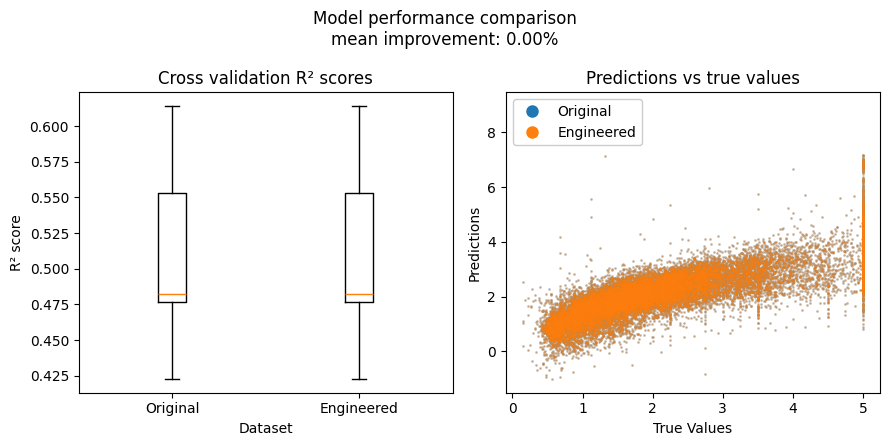

In [ ]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

In [ ]:
**Your reflection**:

*Write your thoughts here...*